## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import logging

#0. Setup Logging
#(1)Create Log record
logger1 = logging.getLogger("log1")
logger1.setLevel(logging.DEBUG)
logger2 = logging.getLogger("log2")
logger2.setLevel(logging.DEBUG)

#(2)Create file handler
fh1 = logging.FileHandler("log1.txt", mode='w')
fh1.setLevel(logging.DEBUG)
fh1_formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(filename)s - %(name)s - %(funcName)s - %(message)s')
fh1.setFormatter(fh1_formatter)
logger1.addHandler(fh1)
fh2 = logging.FileHandler("log2.txt", mode='w')
fh2.setLevel(logging.DEBUG)
fh2_formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(filename)s - %(name)s - %(funcName)s - %(message)s')
fh2.setFormatter(fh2_formatter)
logger2.addHandler(fh2)

#(3)Avoid multipul debug messages
logger1.propagate = False
logger2.propagate = False

#(4)Use it to disable logging
#logging1.disable(logging.FATAL)


#1. Camera Calibration

#(1)prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

#(2)Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

#(3)Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

#(4)Step through the list and search for chessboard corners
for fname in images:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw the Chessboard Corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #plt.imshow(img)

        # Get the parameters of Camera Calibration
        ret, mtx, dist,rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
        
        # Undistorting test images
        undist = cv2.undistort(img, mtx, dist, None, mtx)
        
        logger1.debug(fname)
        logger1.debug(mtx)
        logger1.debug(dist)        
        
        # Plot original image and undistorted image
        if 0:
            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
            f.tight_layout()
            ax1.imshow(img)
            ax1.set_title('Original Image'+fname, fontsize=20)
            ax2.imshow(undist)
            ax2.set_title('Undistorted Image'+fname, fontsize=20)
            plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

            cv2.imwrite('before_'+fname+'.jpg', img)
            cv2.imwrite('after_'+fname+'.jpg', undist) 
        
#(5)Remove logging handler to avoid duplication
logger1.removeHandler(fh1)


## And so on and so forth...

True

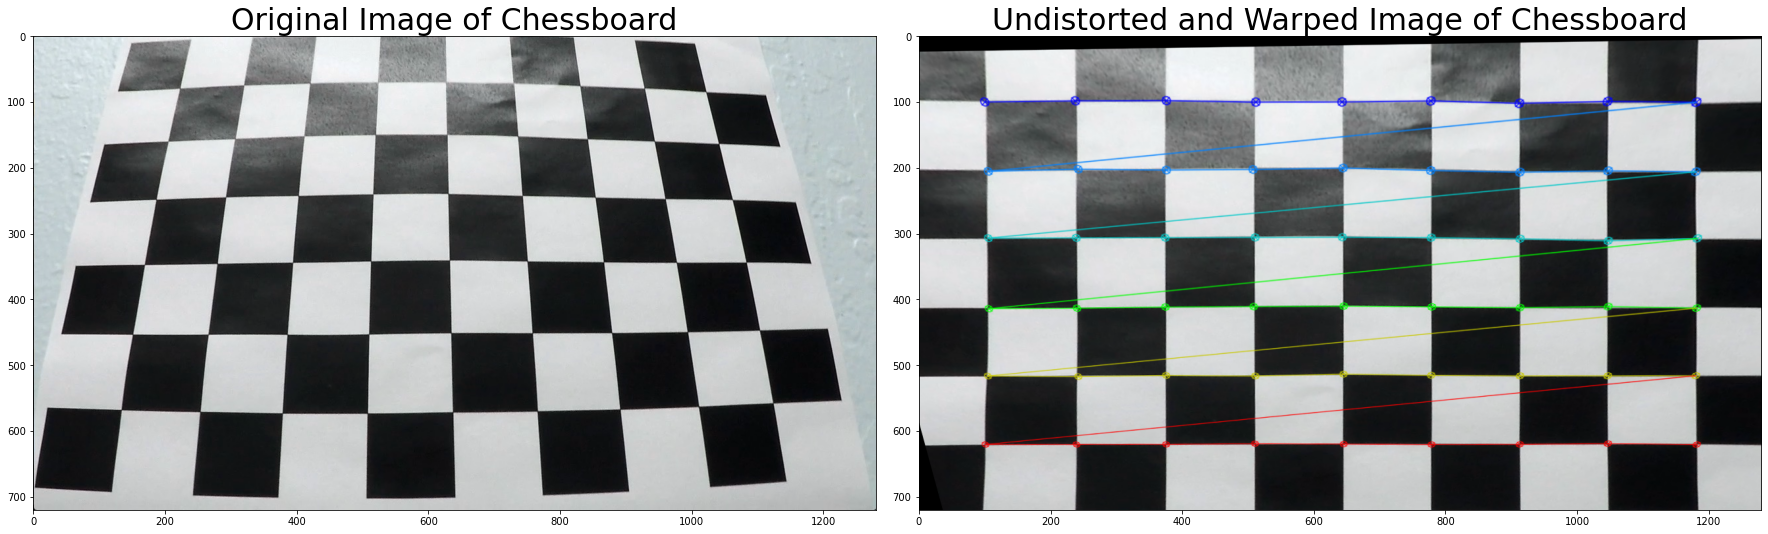

In [2]:
#2. Distortion Correction
#Apply a distortion correction to raw images.
#refer Lesson5, section 18

#(1)Distortion Correction and Perspective Transform of Chessboard
#Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
# Read Chessboard in an image
img = cv2.imread('camera_cal/calibration3.jpg')
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

# Calculate "M" for Perspective Transform
def corners_unwarp(img, nx, ny, mtx, dist):    
    img_size = (img.shape[1], img.shape[0])

    # 1) Undistort using mtx and dist, which were calculated before.
    # Calibration is not needed, because mtx and dist are already exist.
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    img = undist

    # 2) Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # 3) Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None) 

    # 4) If corners found: 
    if ret == True:

            # a) draw corners
            img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)

            # b) define 4 source points src = np.float32([[,],[,],[,],[,]])
            src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]]) # Model Answer    

            # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
            offset = 100 #Model Answer
            dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])

            # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
            M = cv2.getPerspectiveTransform(src, dst)

            # e) use cv2.warpPerspective() to warp my image to a top-down view
            warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return warped, M

# Show the result of Perspective Transform with Chessboard
top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image of Chessboard', fontsize=30)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image of Chessboard', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#(2)Apply a distortion correction to raw images
# Using List doesn't work well, so read each image each time.
straight_lines1 =  mpimg.imread('test_images/straight_lines1.jpg')
straight_lines2 =  mpimg.imread('test_images/straight_lines2.jpg')
test1 =  mpimg.imread('test_images/test1.jpg')
test2 =  mpimg.imread('test_images/test2.jpg')
test3 =  mpimg.imread('test_images/test3.jpg')
test4 =  mpimg.imread('test_images/test4.jpg')
test5 =  mpimg.imread('test_images/test5.jpg')
test6 =  mpimg.imread('test_images/test6.jpg')

# Undistort each image
undist_straight_lines1 = cv2.undistort(straight_lines1, mtx, dist, None, mtx)
undist_straight_lines2 = cv2.undistort(straight_lines2, mtx, dist, None, mtx)
undist_test1 = cv2.undistort(test1, mtx, dist, None, mtx)
undist_test2 = cv2.undistort(test2, mtx, dist, None, mtx)
undist_test3 = cv2.undistort(test3, mtx, dist, None, mtx)
undist_test4 = cv2.undistort(test4, mtx, dist, None, mtx)
undist_test5 = cv2.undistort(test5, mtx, dist, None, mtx)
undist_test6 = cv2.undistort(test6, mtx, dist, None, mtx)

# Show the result of Perspective Transform with Chessboard
if 0:
    f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(straight_lines1)
    ax1.set_title('Original Image: straight_lines1', fontsize=30)
    ax2.imshow(undist_straight_lines1)
    ax2.set_title('Undistorted Image: straight_lines1', fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(straight_lines2)
    ax1.set_title('Original Image: straight_lines2', fontsize=30)
    ax2.imshow(undist_straight_lines2)
    ax2.set_title('Undistorted Image: straight_lines2', fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(test1)
    ax1.set_title('Original Image: test1', fontsize=30)
    ax2.imshow(undist_test1)
    ax2.set_title('Undistorted Image: test1', fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(test2)
    ax1.set_title('Original Image: test2', fontsize=30)
    ax2.imshow(undist_test2)
    ax2.set_title('Undistorted Image: test2', fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(test3)
    ax1.set_title('Original Image: test3', fontsize=30)
    ax2.imshow(undist_test3)
    ax2.set_title('Undistorted Image: test3', fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(test4)
    ax1.set_title('Original Image: test4', fontsize=30)
    ax2.imshow(undist_test4)
    ax2.set_title('Undistorted Image: test4', fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(test5)
    ax1.set_title('Original Image: test5', fontsize=30)
    ax2.imshow(undist_test5)
    ax2.set_title('Undistorted Image: test5', fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(test6)
    ax1.set_title('Original Image: test6', fontsize=30)
    ax2.imshow(undist_test6)
    ax2.set_title('Undistorted Image: test6', fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#Save image files
cv2.imwrite('Original_chess.jpg', img)
cv2.imwrite('Warped_chess.jpg', top_down) 
cv2.imwrite('undist_straight_lines1.jpg', cv2.cvtColor(undist_straight_lines1, cv2.COLOR_RGB2BGR))
cv2.imwrite('undist_straight_lines2.jpg', cv2.cvtColor(undist_straight_lines2, cv2.COLOR_RGB2BGR))
cv2.imwrite('undist_test1.jpg',  cv2.cvtColor(undist_test1, cv2.COLOR_RGB2BGR))
cv2.imwrite('undist_test2.jpg',  cv2.cvtColor(undist_test2, cv2.COLOR_RGB2BGR))
cv2.imwrite('undist_test3.jpg',  cv2.cvtColor(undist_test3, cv2.COLOR_RGB2BGR))
cv2.imwrite('undist_test4.jpg',  cv2.cvtColor(undist_test4, cv2.COLOR_RGB2BGR))
cv2.imwrite('undist_test5.jpg',  cv2.cvtColor(undist_test5, cv2.COLOR_RGB2BGR))
cv2.imwrite('undist_test6.jpg',  cv2.cvtColor(undist_test6, cv2.COLOR_RGB2BGR))


In [3]:
#3. Color and Gradient Threshold
#Use color transforms, gradients, etc., to create a thresholded binary image.

#Define a function that thresholds the S-channel of HLS and Sobel gradient
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    color_binary = np.dstack((sxbinary|s_binary, sxbinary|s_binary, sxbinary|s_binary)) * 255 #Try showing white color
    return color_binary
    
# Tune the threshold to try to match the images
hls_straight_lines1 = pipeline(undist_straight_lines1)
hls_straight_lines2 = pipeline(undist_straight_lines2)
hls_test1 = pipeline(undist_test1)
hls_test2 = pipeline(undist_test2)
hls_test3 = pipeline(undist_test3)
hls_test4 = pipeline(undist_test4)
hls_test5 = pipeline(undist_test5)
hls_test6 = pipeline(undist_test6)

# Plot the result
# Green is Gradiend Threshold Component
# Blue is Color Channel Threshold Component
if 0:
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(undist_straight_lines1)
    ax1.set_title('Original Image: straight_lines1', fontsize=30)
    ax2.imshow(hls_straight_lines1, cmap='gray')
    ax2.set_title('Thresholded S: straight_lines1', fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(undist_straight_lines2)
    ax1.set_title('Original Image: straight_lines2', fontsize=30)
    ax2.imshow(hls_straight_lines2, cmap='gray')
    ax2.set_title('Thresholded S: straight_lines2', fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(undist_test1)
    ax1.set_title('Original Image: test1', fontsize=30)
    ax2.imshow(hls_test1, cmap='gray')
    ax2.set_title('Thresholded S: test1', fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(undist_test2)
    ax1.set_title('Original Image: test2', fontsize=30)
    ax2.imshow(hls_test2, cmap='gray')
    ax2.set_title('Thresholded S: test2', fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(undist_test3)
    ax1.set_title('Original Image: test3', fontsize=30)
    ax2.imshow(hls_test3, cmap='gray')
    ax2.set_title('Thresholded S: test3', fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(undist_test4)
    ax1.set_title('Original Image: test4', fontsize=30)
    ax2.imshow(hls_test4, cmap='gray')
    ax2.set_title('Thresholded S: test4', fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(undist_test5)
    ax1.set_title('Original Image: test5', fontsize=30)
    ax2.imshow(hls_test5, cmap='gray')
    ax2.set_title('Thresholded S: test5', fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(undist_test6)
    ax1.set_title('Original Image: test6', fontsize=30)
    ax2.imshow(hls_test6, cmap='gray')
    ax2.set_title('Thresholded S: test6', fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#Save image files
cv2.imwrite('thresholded_test1.jpg', hls_test1)
cv2.imwrite('thresholded_test2.jpg', hls_test2)
cv2.imwrite('thresholded_test3.jpg', hls_test3)
cv2.imwrite('thresholded_test4.jpg', hls_test4)
cv2.imwrite('thresholded_test5.jpg', hls_test5)
cv2.imwrite('thresholded_test6.jpg', hls_test6)

True

In [4]:
#4. Perspective Transform to bird view
#Apply a perspective transform to rectify binary image ("birds-eye view").
#   Should try with 2 straight line images

#(1)Create warp function which fits well with straight lines images.
# Save RGB color images to get good src points (if we use cv2.imwrite(), should be converted)
save_img1 = cv2.cvtColor(undist_straight_lines1, cv2.COLOR_RGB2BGR)
save_img2 = cv2.cvtColor(undist_straight_lines2, cv2.COLOR_RGB2BGR)
cv2.imwrite("undist_straight_lines1.jpg",save_img1)
cv2.imwrite("undist_straight_lines2.jpg",save_img2)

#Warp function
def warp(img):
    
    # Define calibration box in source and destination
    img_size = (img.shape[1], img.shape[0])
    
    # Get src from undistorted images
    src1 = np.float32([[708,462],[1053,688],[246,688],[577,462]]) # undist_straight_lines1  
    #src1 = np.float32([[662,436],[1053,688],[246,688],[617,436]]) # undist_straight_lines1  
    src2 = np.float32([[678,441],[1040,675],[280,675],[607,441]]) # undist_straight_lines2  
    src = (src1 + src2)/2 # Use average to get more robust src
    offsetx = 300
    offsety = 0
    dst = np.float32([[img_size[0]-offsetx,offsety],[img_size[0]-offsetx,img_size[1]-offsety],[offsetx,img_size[1]],[offsetx,offsety]])
    
    #logger2.debug(img.shape[0])
    #logger2.debug(img.shape[1])
    
    # Compute the perspective transform, M
    M = cv2.getPerspectiveTransform(src, dst)
   
    # Create warped image
    warped = cv2.warpPerspective(img, M, img_size, flags = cv2.INTER_LINEAR)
    
    return warped
    
# Generate warped images from straight lines images
warped_straight_lines1 = warp(undist_straight_lines1)
warped_straight_lines2 = warp(undist_straight_lines2)

# Plot the result
if 0:
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(undist_straight_lines1)
    ax1.set_title('Original Image: straight_lines1', fontsize=30)
    ax2.imshow(warped_straight_lines1, cmap='gray')
    ax2.set_title('Warped Image: straight_lines1', fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(undist_straight_lines2)
    ax1.set_title('Original Image: straight_lines2', fontsize=30)
    ax2.imshow(warped_straight_lines2, cmap='gray')
    ax2.set_title('Warped Image: straight_lines2', fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#Save image files
cv2.imwrite('warped_straight_lines1.jpg', cv2.cvtColor(warped_straight_lines1, cv2.COLOR_RGB2BGR))
cv2.imwrite('warped_straight_lines2.jpg', cv2.cvtColor(warped_straight_lines2, cv2.COLOR_RGB2BGR))

#(2)Adapt warp to the previous Thresholded imates
# Generate warped images
warped_test1 = warp(cv2.cvtColor(hls_test1, cv2.COLOR_RGB2GRAY))
warped_test2 = warp(cv2.cvtColor(hls_test2, cv2.COLOR_RGB2GRAY))
warped_test3 = warp(cv2.cvtColor(hls_test3, cv2.COLOR_RGB2GRAY))
warped_test4 = warp(cv2.cvtColor(hls_test4, cv2.COLOR_RGB2GRAY))
warped_test5 = warp(cv2.cvtColor(hls_test5, cv2.COLOR_RGB2GRAY))
warped_test6 = warp(cv2.cvtColor(hls_test6, cv2.COLOR_RGB2GRAY))

# Plot the result
if 0:
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(undist_test1)
    ax1.set_title('Original Image: test1', fontsize=30)
    ax2.imshow(warped_test1, cmap='gray')
    ax2.set_title('Warped Image: test1', fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(undist_test2)
    ax1.set_title('Original Image: test2', fontsize=30)
    ax2.imshow(warped_test2, cmap='gray')
    ax2.set_title('Warped Image: test2', fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(undist_test3)
    ax1.set_title('Original Image: test3', fontsize=30)
    ax2.imshow(warped_test3, cmap='gray')
    ax2.set_title('Warped Image: test3', fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(undist_test4)
    ax1.set_title('Original Image: test4', fontsize=30)
    ax2.imshow(warped_test4, cmap='gray')
    ax2.set_title('Warped Image: test4', fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(undist_test5)
    ax1.set_title('Original Image: test5', fontsize=30)
    ax2.imshow(warped_test5, cmap='gray')
    ax2.set_title('Warped Image: test5', fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(undist_test6)
    ax1.set_title('Original Image: test6', fontsize=30)
    ax2.imshow(warped_test6, cmap='gray')
    ax2.set_title('Warped Image: test6', fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#Save image files
cv2.imwrite('warped_test1.jpg', warped_test1)
cv2.imwrite('warped_test2.jpg', warped_test2)
cv2.imwrite('warped_test3.jpg', warped_test3)
cv2.imwrite('warped_test4.jpg', warped_test4)
cv2.imwrite('warped_test5.jpg', warped_test5)
cv2.imwrite('warped_test6.jpg', warped_test6)


#(5)Remove logging handler to avoid duplication
#logger2.removeHandler(fh2)

True

True

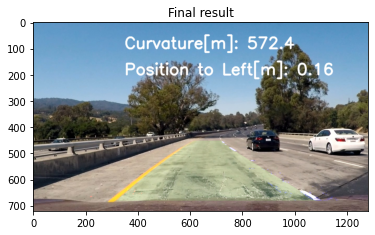

In [5]:
#5. Finding the Lanes
#Detect lane pixels and fit to find the lane boundary.

binary_warped = warped_test1
file_name = "test1"
original_img = test1

#Mode = 1 # Until Step 7: Plot Lane Lines area with green color
Mode = 2 # Step 8: Plot Lane area with green color for movie file

#(1) Peaks in Histogram by Sliding Window
#Findind pixels by using hystogram
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    #midpoint = np.int(histogram.shape[0]//2) #There's warning if I use np.int...
    midpoint = int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    #minpix = 50 # If it's 50, it's not good at test4.jpg...
    minpix = 200

    # Set height of windows - based on nwindows above and image shape
    #window_height = np.int(binary_warped.shape[0]//nwindows) #There's warning if I use np.int...
    window_height = int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current-margin  # Update this
        win_xleft_high = leftx_current+margin  # Update this
        win_xright_low = rightx_current-margin  # Update this
        win_xright_high = rightx_current+margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        #pass # Remove this when you add your function
        if len(good_left_inds) > minpix:
            #leftx_current = np.int(np.mean(nonzerox[good_left_inds]))#There's warning if I use np.int...
            leftx_current = int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = int(np.mean(nonzerox[good_right_inds]))#There's warning if I use np.int...
            #rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

#Calculate fitting polynomial
def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')

    #return out_img
    return out_img, left_fit, right_fit # Add left_fit,right_fit for the next step

#Get result of fitting polynomial
out_img, left_fit, right_fit = fit_polynomial(binary_warped)
#plt.imshow(out_img)
#cv2.imwrite('output_images/Find_from_Histogram_'+file_name+'.jpg', out_img)

#(2)Search lines from Polynomial fit values from the previous frame
#def fit_poly(img_shape, leftx, lefty, rightx, righty):
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped, xm_per_pix, ym_per_pix):  
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    #Calculate left_fit, right_fit for Curvature measuring
    left_fit_pix = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_pix = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    left_fitx_pix = left_fitx*xm_per_pix
    right_fitx_pix = right_fitx*xm_per_pix
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    if Mode == 1:
        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

        # Plot the polynomial lines onto the image
        #plt.plot(left_fitx, ploty, color='yellow')
        #plt.plot(right_fitx, ploty, color='yellow')
        ## End visualization steps ##
    
    elif Mode == 2:
        # Draw the lane onto the warped blank image
        final_line_window1 = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        final_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        final_line_pts = np.hstack((final_line_window1, final_line_window2))
        cv2.fillPoly(window_img, np.int_([final_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
       
    #return result
    return result, left_fit_pix, right_fit_pix, left_fitx_pix, right_fitx_pix # Add values to calculate curvature

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension #Define outside
xm_per_pix = 3.7/700 # meters per pixel in x dimension #Define outside

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
#result = search_around_poly(binary_warped)
result, left_fit_pix, right_fit_pix, left_fitx_pix, right_fitx_pix = search_around_poly(binary_warped, xm_per_pix, ym_per_pix)
cv2.imwrite('output_images/Search_from_Prior_'+file_name+'.jpg',result)

#(3)Show the result
#plt.figure() #Somehow, if there are multiple graphs, the yellow lines become strange.
#plt.imshow(out_img)
#plt.title('Result of Fiding lanes from histogram')
#plt.figure()
#plt.imshow(result)
#plt.title('Result of Searching from prior')


#6. Measuring curvature and vehicle position
#Determine the curvature of the lane and vehicle position with respect to center.

#(1)Measuring curvature 

def measure_curvature_real():  
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    #ym_per_pix = 30/720 # meters per pixel in y dimension # Define outside
    #xm_per_pix = 3.7/700 # meters per pixel in x dimension # Define outside
    
    # Use Meter-based left_fit, right_fit
    left_fit_cr = left_fit_pix
    right_fit_cr = right_fit_pix
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    #y_eval = np.max(ploty)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    y_eval = np.max(ploty)* ym_per_pix
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    #print(y_eval)
    #print(left_fit_cr[0],left_fit_cr[1],left_fit_cr[2])
    #print(right_fit_cr[0],right_fit_cr[1],right_fit_cr[2])

    return left_curverad, right_curverad


# Calculate the radius of curvature in meters for both lane lines
left_curverad, right_curverad = measure_curvature_real()
curverad = (left_curverad + right_curverad)/2.0 # Resulting curvature is average of left & right

#print(left_curverad, right_curverad, curverad)


#(2)Measuring vehicle position
center = result.shape[1]/2.0*xm_per_pix
position = (left_fitx_pix[-1] + right_fitx_pix[-1])/2.0 - center

#(3)Show the result (Show Curvature and Vehicle position)
#plt.imshow(result)
#plt.title('Result of Searching from prior')
#cv2.imwrite('output_images/Curvature_Position_'+file_name+'.jpg',result)


#7. Warp back onto original
# Warp the detected lane boundaries back onto the original image.

#(1)Unwarp function (refered warp function)
def unwarp(img):
    # Define calibration box in source and destination
    img_size = (img.shape[1], img.shape[0])
    
    # Get src from undistorted images
    src1 = np.float32([[708,462],[1053,688],[246,688],[577,462]]) # undist_straight_lines1  
    src2 = np.float32([[678,441],[1040,675],[280,675],[607,441]]) # undist_straight_lines2  
    src = (src1 + src2)/2 # Use average to get more robust src
    offsetx = 300
    offsety = 0
    dst = np.float32([[img_size[0]-offsetx,offsety],[img_size[0]-offsetx,img_size[1]-offsety],[offsetx,img_size[1]],[offsetx,offsety]])
       
    # Compute the perspective transform, M
    M = cv2.getPerspectiveTransform(dst, src)# Switch src and dst to calculate unwarp
   
    # Create warped image
    unwarped = cv2.warpPerspective(img, M, img_size, flags = cv2.INTER_LINEAR)
    
    return unwarped

#(2)Unwarp lane finding image and plot onto the original image
unwarped = unwarp(result)
#final_result = unwarped
final_result = cv2.addWeighted(original_img, 1.0, unwarped, 0.3, 0)

#(3)Show the result
text1 = "Curvature[m]: " + str(round(curverad, 1))
if position > 0:
    text2 = "Position to Left[m]: " + str(round(abs(position), 3))
else:
    text2 = "Position to Right[m]: " + str(round(abs(position), 3))
cv2.putText(final_result, text1, (350, 100), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 5, cv2.LINE_AA)
cv2.putText(final_result, text2, (350, 200), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 5, cv2.LINE_AA)

plt.imshow(final_result)
plt.title('Final result')
cv2.imwrite('output_images/Final_result_'+file_name+'.jpg',cv2.cvtColor(final_result,cv2.COLOR_BGR2RGB))

In [18]:
#8. Run Video File
#Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

#(1)Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

#(2)Use my pipeline
def process_image(image):
    #2. Distortion Correction
    undist_img = cv2.undistort(image, mtx, dist, None, mtx)

    #3. Color and Gradient Threshold
    #Define a function that thresholds the S-channel of HLS and Sobel gradient
    def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
        img = np.copy(img)
        # Convert to HLS color space and separate the V channel
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        l_channel = hls[:,:,1]
        s_channel = hls[:,:,2]
        # Sobel x
        sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
        abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

        # Threshold x gradient
        sxbinary = np.zeros_like(scaled_sobel)
        sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

        # Threshold color channel
        s_binary = np.zeros_like(s_channel)
        s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
        # Stack each channel
        #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
        color_binary = np.dstack((sxbinary|s_binary, sxbinary|s_binary, sxbinary|s_binary)) * 255 #Try showing white color
        return color_binary

    # Tune the threshold to try to match the images
    hls_img = pipeline(undist_img)

    #4. Perspective Transform to bird view
    #Warp function
    def warp(img):
        # Define calibration box in source and destination
        img_size = (img.shape[1], img.shape[0])

        # Get src from undistorted images
        src1 = np.float32([[708,462],[1053,688],[246,688],[577,462]]) # undist_straight_lines1  
        #src1 = np.float32([[662,436],[1053,688],[246,688],[617,436]]) # undist_straight_lines1  
        src2 = np.float32([[678,441],[1040,675],[280,675],[607,441]]) # undist_straight_lines2  
        src = (src1 + src2)/2 # Use average to get more robust src
        offsetx = 300
        offsety = 0
        dst = np.float32([[img_size[0]-offsetx,offsety],[img_size[0]-offsetx,img_size[1]-offsety],[offsetx,img_size[1]],[offsetx,offsety]])

        #logger2.debug(img.shape[0])
        #logger2.debug(img.shape[1])

        # Compute the perspective transform, M
        M = cv2.getPerspectiveTransform(src, dst)

        # Create warped image
        warped = cv2.warpPerspective(img, M, img_size, flags = cv2.INTER_LINEAR)

        return warped

    #(2)Adapt warp to the previous Thresholded imates
    # Generate warped images
    warped_img = warp(cv2.cvtColor(hls_img, cv2.COLOR_RGB2GRAY))

    
    #5. Finding the Lanes
    #Detect lane pixels and fit to find the lane boundary.
    binary_warped = warped_img
    original_img = image

    #(1) Peaks in Histogram by Sliding Window
    #Findind pixels by using hystogram
    def find_lane_pixels(binary_warped):
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        # Create an output image to draw on and visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        #midpoint = np.int(histogram.shape[0]//2) #There's warning if I use np.int...
        midpoint = int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # HYPERPARAMETERS
        # Choose the number of sliding windows
        nwindows = 9
        # Set the width of the windows +/- margin
        margin = 100
        #margin = 50 # In video, make it more robust
        # Set minimum number of pixels found to recenter window
        #minpix = 50 # If it's 50, it's not good at test4.jpg...
        minpix = 200

        # Set height of windows - based on nwindows above and image shape
        #window_height = np.int(binary_warped.shape[0]//nwindows) #There's warning if I use np.int...
        window_height = int(binary_warped.shape[0]//nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated later for each window in nwindows
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            ### TO-DO: Find the four below boundaries of the window ###
            win_xleft_low = leftx_current-margin  # Update this
            win_xleft_high = leftx_current+margin  # Update this
            win_xright_low = rightx_current-margin  # Update this
            win_xright_high = rightx_current+margin  # Update this

            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),
            (win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),
            (win_xright_high,win_y_high),(0,255,0), 2) 

            ### TO-DO: Identify the nonzero pixels in x and y within the window ###
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            ### TO-DO: If you found > minpix pixels, recenter next window ###
            ### (`right` or `leftx_current`) on their mean position ###
            #pass # Remove this when you add your function
            if len(good_left_inds) > minpix:
                #leftx_current = np.int(np.mean(nonzerox[good_left_inds]))#There's warning if I use np.int...
                leftx_current = int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = int(np.mean(nonzerox[good_right_inds]))#There's warning if I use np.int...
                #rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices (previously was a list of lists of pixels)
        try:
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
        except ValueError:
            # Avoids an error if the above is not implemented fully
            pass

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        return leftx, lefty, rightx, righty, out_img

    #Calculate fitting polynomial
    def fit_polynomial(binary_warped):
        # Find our lane pixels first
        leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

        ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
        ##################################################################
        # If the left_fit or right_fit changes a lot, use the global fit.#
        ##################################################################
        global left_fit_global, right_fit_global, cnt1_global, cnt2_global, cnt3_global
        
        if (left_fit_global[2]!=0 and right_fit_global[2]!=0):
            if ((abs(left_fit_global[0] - left_fit[0])>0.001) or (abs(right_fit_global[0] - right_fit[0])>0.001)\
             or (abs(left_fit_global[1] - left_fit[1])>1.0) or (abs(right_fit_global[1] - right_fit[1])>1.0)\
             or (abs(left_fit_global[2] - left_fit[2])>200) or (abs(right_fit_global[2] - right_fit[2])>200)):
                left_fit = left_fit_global
                right_fit = right_fit_global

            else:
                left_fit_global = left_fit
                right_fit_global = right_fit
                cnt2_global += 1

        else:
            left_fit_global = left_fit
            right_fit_global =  right_fit
            cnt3_global += 1
        ###################################################################

        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        try:
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        except TypeError:
            # Avoids an error if `left` and `right_fit` are still none or incorrect
            print('The function failed to fit a line!')
            left_fitx = 1*ploty**2 + 1*ploty
            right_fitx = 1*ploty**2 + 1*ploty

        ## Visualization ##
        # Colors in the left and right lane regions
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]

        # Plots the left and right polynomials on the lane lines
        #plt.plot(left_fitx, ploty, color='yellow')
        #plt.plot(right_fitx, ploty, color='yellow')

        #return out_img
        return out_img, left_fit, right_fit # Add left_fit,right_fit for the next step

    #Get result of fitting polynomial
    out_img, left_fit, right_fit = fit_polynomial(binary_warped)
    #plt.imshow(out_img)
    #cv2.imwrite('output_images/Find_from_Histogram_'+file_name+'.jpg', out_img)

    #(2)Search lines from Polynomial fit values from the previous frame
    #def fit_poly(img_shape, leftx, lefty, rightx, righty):
    def fit_poly(img_shape, leftx, lefty, rightx, righty):
        ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###

        #left_fit = np.polyfit(lefty, leftx, 2)
        #right_fit = np.polyfit(righty, rightx, 2)      

        ##################################################################
        # Smoothing left_fit and right_fit                               #
        ##################################################################
        global left_fit_global2, right_fit_global2, left_fit_global3, right_fit_global3
        
        if (len(leftx)==0 or len(rightx)==0):
            left_fit = left_fit_global2
            right_fit = right_fit_global2
        else:
            left_fit = np.polyfit(lefty, leftx, 2)
            right_fit = np.polyfit(righty, rightx, 2)    
        
        if (left_fit_global2[2]!=0 and right_fit_global2[2]!=0 and left_fit_global3[2]!=0 and right_fit_global3[2]!=0):
            for i in range(3):
                left_fit[i] = left_fit_global2[i]*0.4 + left_fit_global3[i]*0.4 + left_fit[i]*0.2
                right_fit[i] = right_fit_global2[i]*0.4 + right_fit_global3[i]*0.4 + right_fit[i]*0.2
                #left_fit[i] = left_fit_global2[i]*0.2 + left_fit_global3[i]*0.2 + left_fit[i]*0.6
                #right_fit[i] = right_fit_global2[i]*0.2 + right_fit_global3[i]*0.2 + right_fit[i]*0.6

        left_fit_global3 = left_fit_global2
        right_fit_global3 = right_fit_global2
        left_fit_global2 = left_fit
        right_fit_global2 =  right_fit
        ###################################################################
        
        # Generate x and y values for plotting
        ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
        ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        return left_fitx, right_fitx, ploty

    def search_around_poly(binary_warped, xm_per_pix, ym_per_pix):     
        
        # HYPERPARAMETER
        # Choose the width of the margin around the previous polynomial to search
        #margin = 100
        margin = 50 # More stables

        # Grab activated pixels
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        ### TO-DO: Set the area of search based on activated x-values ###
        ### within the +/- margin of our polynomial function ###
        ### Hint: consider the window areas for the similarly named variables ###
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                        left_fit[1]*nonzeroy + left_fit[2] + margin)))
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                        right_fit[1]*nonzeroy + right_fit[2] + margin)))

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        
        # Fit new polynomials
        left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
        
        #Calculate left_fit, right_fit for Curvature measuring
        global left_fit_pix_global, right_fit_pix_global
        
        if (len(leftx) == 0 or len(righty)==0):
            left_fit_pix = left_fit_pix_global
            right_fit_pix = right_fit_pix_global
        else:
            left_fit_pix = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
            right_fit_pix = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
            left_fit_pix = left_fit_pix
            right_fit_pix_global = right_fit_pix

        left_fitx_pix = left_fitx*xm_per_pix
        right_fitx_pix = right_fitx*xm_per_pix

        ## Visualization ##
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        final_line_window1 = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        final_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        final_line_pts = np.hstack((final_line_window1, final_line_window2))
        cv2.fillPoly(window_img, np.int_([final_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

        #return result
        return result, left_fit_pix, right_fit_pix, left_fitx_pix, right_fitx_pix # Add values to calculate curvature

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension #Define outside
    xm_per_pix = 3.7/700 # meters per pixel in x dimension #Define outside

    # Run image through the pipeline
    # Note that in your project, you'll also want to feed in the previous fits
    #result = search_around_poly(binary_warped)
    result, left_fit_pix, right_fit_pix, left_fitx_pix, right_fitx_pix = search_around_poly(binary_warped, xm_per_pix, ym_per_pix)
    #cv2.imwrite('output_images/Search_from_Prior_'+file_name+'.jpg',result)

    #(3)Show the result
    #plt.figure() #Somehow, if there are multiple graphs, the yellow lines become strange.
    #plt.imshow(out_img)
    #plt.title('Result of Fiding lanes from histogram')
    #plt.figure()
    #plt.imshow(result)
    #plt.title('Result of Searching from prior')


    #6. Measuring curvature and vehicle position
    #Determine the curvature of the lane and vehicle position with respect to center.

    #(1)Measuring curvature 

    def measure_curvature_real():  
        '''
        Calculates the curvature of polynomial functions in meters.
        '''
        # Define conversions in x and y from pixels space to meters
        #ym_per_pix = 30/720 # meters per pixel in y dimension # Define outside
        #xm_per_pix = 3.7/700 # meters per pixel in x dimension # Define outside

        # Use Meter-based left_fit, right_fit
        left_fit_cr = left_fit_pix
        right_fit_cr = right_fit_pix

        # Define y-value where we want radius of curvature
        # We'll choose the maximum y-value, corresponding to the bottom of the image
        #y_eval = np.max(ploty)
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        y_eval = np.max(ploty)* ym_per_pix

        # Calculation of R_curve (radius of curvature)
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

        #print(y_eval)
        #print(left_fit_cr[0],left_fit_cr[1],left_fit_cr[2])
        #print(right_fit_cr[0],right_fit_cr[1],right_fit_cr[2])

        return left_curverad, right_curverad


    # Calculate the radius of curvature in meters for both lane lines
    left_curverad, right_curverad = measure_curvature_real()
    curverad = (left_curverad + right_curverad)/2.0 # Resulting curvature is average of left & right

    #print(left_curverad, right_curverad, curverad)


    #(2)Measuring vehicle position
    center = result.shape[1]/2.0*xm_per_pix
    position = (left_fitx_pix[-1] + right_fitx_pix[-1])/2.0 - center

    #(3)Show the result (Show Curvature and Vehicle position)
    #text1 = "Curvature[m]: " + str(round(curverad, 3))
    #text2 = "Position[m]: " + str(round(position, 3))
    #cv2.putText(result, text1, (350, 100), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), 5, cv2.LINE_AA)
    #cv2.putText(result, text2, (350, 200), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), 5, cv2.LINE_AA)
    #plt.imshow(result)
    #plt.title('Result of Searching from prior')
    #cv2.imwrite('output_images/Curvature_Position_'+file_name+'.jpg',result)


    #7. Warp back onto original
    # Warp the detected lane boundaries back onto the original image.

    #(1)Unwarp function (refered warp function)
    def unwarp(img):
        # Define calibration box in source and destination
        img_size = (img.shape[1], img.shape[0])

        # Get src from undistorted images
        src1 = np.float32([[708,462],[1053,688],[246,688],[577,462]]) # undist_straight_lines1  
        src2 = np.float32([[678,441],[1040,675],[280,675],[607,441]]) # undist_straight_lines2  
        src = (src1 + src2)/2 # Use average to get more robust src
        offsetx = 300
        offsety = 0
        dst = np.float32([[img_size[0]-offsetx,offsety],[img_size[0]-offsetx,img_size[1]-offsety],[offsetx,img_size[1]],[offsetx,offsety]])

        # Compute the perspective transform, M
        M = cv2.getPerspectiveTransform(dst, src)# Switch src and dst to calculate unwarp

        # Create warped image
        unwarped = cv2.warpPerspective(img, M, img_size, flags = cv2.INTER_LINEAR)

        return unwarped

    #(2)Unwarp lane finding image and plot onto the original image
    unwarped = unwarp(result)
    #final_result = unwarped
    final_result = cv2.addWeighted(original_img, 1.0, unwarped, 0.5, 0)
    
    #(3)Add texts on the image
    text1 = "Curvature[m]: " + str(round(curverad, 1))
    if position > 0:
        text2 = "Position to Left[m]: " + str(round(abs(position), 3))
    else:
        text2 = "Position to Right[m]: " + str(round(abs(position), 3))
        
    cv2.putText(final_result, text1, (350, 100), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 5, cv2.LINE_AA)
    cv2.putText(final_result, text2, (350, 200), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 5, cv2.LINE_AA)

    #############################################################################
    # Add extra information for debugging.
    #############################################################################
    np.set_printoptions(suppress=False, precision=2)
    text3 = "left_fit:"+str(left_fit)+", right_fit:"+str(right_fit)
    text4 = "left_global:"+str(left_fit_global)+", right_global:"+str(right_fit_global)
    cv2.putText(final_result, text3, (350, 300), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 2, cv2.LINE_AA)
    cv2.putText(final_result, text4, (350, 350), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 2, cv2.LINE_AA)
    
    img1 = cv2.resize(out_img,(320,180))
    final_result[0:img1.shape[0], 0:img1.shape[1]] = img1
    
    img2 = cv2.resize(result,(320,180))
    final_result[200:200+img2.shape[0], 0:img2.shape[1]] = img2
    #############################################################################
    
    return final_result

In [21]:
#(3)Create video after my pipeline
output = 'test_videos_output/project_video_output.mp4'

left_fit_global = [0,0,0]
right_fit_global = [0,0,0]
left_fit_global2 = [0,0,0]
right_fit_global2 = [0,0,0]
left_fit_global3 = [0,0,0]
right_fit_global3 = [0,0,0]
cnt1_global = 0
cnt2_global = 0
cnt3_global = 0
left_fit_pix_global = [0,0,0]
right_fit_pix_global = [0,0,0]

## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
#clip1 = VideoFileClip("project_video.mp4").subclip(15,30)
clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time clip.write_videofile(output, audio=False)



                                                          
t:   1%|          | 6/1199 [48:51<03:10,  6.26it/s, now=None]
                                                          
t:   1%|          | 6/1199 [48:51<03:10,  6.26it/s, now=None]

Moviepy - Building video test_videos_output/project_video_output.mp4.
Moviepy - Writing video test_videos_output/project_video_output.mp4



                                                                
                                                          
t:   1%|          | 6/1199 [51:25<03:10,  6.26it/s, now=None]
                                                          
t:   1%|          | 6/1199 [51:25<03:10,  6.26it/s, now=None]

Moviepy - Done !
Moviepy - video ready test_videos_output/project_video_output.mp4
Wall time: 2min 34s


In [19]:
#(3)Create video after my pipeline (Challenge Video)
output = 'test_videos_output/challenge_video_output.mp4'

left_fit_global = [0,0,0]
right_fit_global = [0,0,0]
left_fit_global2 = [0,0,0]
right_fit_global2 = [0,0,0]
left_fit_global3 = [0,0,0]
right_fit_global3 = [0,0,0]
cnt1_global = 0
cnt2_global = 0
cnt3_global = 0
left_fit_pix_global = [0,0,0]
right_fit_pix_global = [0,0,0]

## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("challenge_video.mp4")
clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time clip.write_videofile(output, audio=False)


                                                          
t:   1%|          | 6/1199 [29:29<03:10,  6.26it/s, now=None]
                                                          
t:   1%|          | 6/1199 [29:29<03:10,  6.26it/s, now=None]

Moviepy - Building video test_videos_output/challenge_video_output.mp4.
Moviepy - Writing video test_videos_output/challenge_video_output.mp4



                                                              
                                                          
t:   1%|          | 6/1199 [30:18<03:10,  6.26it/s, now=None]
                                                          
t:   1%|          | 6/1199 [30:18<03:10,  6.26it/s, now=None]

Moviepy - Done !
Moviepy - video ready test_videos_output/challenge_video_output.mp4
Wall time: 48.6 s


In [20]:
#(3)Create video after my pipeline (Harder challenge video)
output = 'test_videos_output/harder_challenge_video_output.mp4'

left_fit_global = [0,0,0]
right_fit_global = [0,0,0]
left_fit_global2 = [0,0,0]
right_fit_global2 = [0,0,0]
left_fit_global3 = [0,0,0]
right_fit_global3 = [0,0,0]
cnt1_global = 0
cnt2_global = 0
cnt3_global = 0
left_fit_pix_global = [0,0,0]
right_fit_pix_global = [0,0,0]

## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("harder_challenge_video.mp4")
clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time clip.write_videofile(output, audio=False)


                                                          
t:   1%|          | 6/1199 [32:29<03:10,  6.26it/s, now=None]
                                                          
t:   1%|          | 6/1199 [32:29<03:10,  6.26it/s, now=None]

Moviepy - Building video test_videos_output/harder_challenge_video_output.mp4.
Moviepy - Writing video test_videos_output/harder_challenge_video_output.mp4



                                                                
                                                          
t:   1%|          | 6/1199 [35:28<03:10,  6.26it/s, now=None]
                                                          
t:   1%|          | 6/1199 [35:28<03:10,  6.26it/s, now=None]

Moviepy - Done !
Moviepy - video ready test_videos_output/harder_challenge_video_output.mp4
Wall time: 2min 59s
